# Brunner Data Science Task #
## Premise ##
Eric has been tracking his bike commutes to and from work. My task is to tell a story with the data:
* What do I observe?
* Describe trends and changes over time
* What factors affect his time?
* What are the implications of my findings?
## Knowns ##
* Eric bikes from the office at 11 Stanwix St. to the Point Breeze area
* Eric's commute is downhill in the mornings and uphill in the evenings
* Eric recently got a Kona gravel bike with wider tires and felt slower on his 2 most recent rides

## Assumptions ##
* Eric's morning commute takes place between 6 and 8 am
* Eric's evening commute takes place between 5 and 7 pm

## Wrangling and EDA ##

In [33]:
import arviz as az
import xarray as xr
import pandas as pd
import scipy
import datetime as dt
from weather import get_pgh_weather
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import pymc as pm
import ipywidgets
#from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Reading in the data and merging on the route column
times_df = pd.read_excel('data.xlsx', sheet_name = 'raw_data')
key_df = pd.read_excel('data.xlsx', sheet_name = 'route_lookup')
raw_df = times_df.merge(right = key_df, how = 'left', on = 'route')
raw_df.head()

,date,temperature_f,destination,time,route,distance_miles
0,2019-03-20,26,Work,00:36:36,A,7.4
1,2019-03-20,56,Home,00:40:54,A,7.4
2,2019-03-28,39,Work,00:35:01,A,7.4
3,2019-03-28,61,Home,00:39:20,A,7.4
4,2019-04-03,35,Work,00:36:49,A,7.4


In [5]:
raw_df.describe()

,date,temperature_f,distance_miles
count,125,125.000000,125.000000
mean,2021-02-12 21:30:14.400000,65.088000,7.414400
min,2019-03-20 00:00:00,26.000000,7.300000
25%,2019-07-23 00:00:00,57.000000,7.400000
50%,2021-05-20 00:00:00,65.000000,7.400000
75%,2022-06-29 00:00:00,75.000000,7.400000
max,2024-03-01 00:00:00,90.000000,8.300000
std,NaN,14.008071,0.124242


### Cleaning ###
Thankfully there are no missing values or data quality issues. I want to simplify the column names, change some data types, and calculate average speed next.

In [6]:
def clean_biking_data(input_df):
    ''' (DataFrame) -> DataFrame
    Returns a cleaned dataframe with simplified feature names, an average speed calculation,
    and rectified data types.
    '''
    output_df = pd.DataFrame()
    output_df['date'] = pd.to_datetime(input_df['date'], format = '%Y-%m-%d').dt.date
    output_df['weekday'] = pd.to_datetime(output_df['date']).dt.weekday.map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})
    output_df['temp_f'] = input_df['temperature_f']
    output_df['destination'] = input_df['destination']
    output_df['time'] = pd.to_timedelta(input_df['time'].astype(str))
    output_df['route'] = input_df['route']
    output_df['miles'] = input_df['distance_miles']
    output_df['avg_mph'] = (output_df['miles']/(output_df['time'].dt.total_seconds()/3600)).round(2)
    return output_df

In [7]:
# Cleaned data
df = clean_biking_data(raw_df)
df.head()

,date,weekday,temp_f,destination,time,route,miles,avg_mph
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06


### Weather Consideration ###
When I used to bike to work, weather was a huge perceived factor in my commute. If the weather was bad enough, I wouldn't bike at all. Otherwise, conditions like temperature and precipitation affected my riding pace and route. Eric provided temperature data but I can also check if there was any precipitation during his commutes, assuming the time estimate is roughly accurate.

In [9]:
def add_weather(input_df):
    ''' (DataFrame) -> DataFrame
    Add the weather code to each commute segment.
    Assumption is morning commute occurs between 6am and 8am. 
    Evening commute occurs between 5pm and 7pm.
    Applies "worst" weather code that occurred during commute.
    '''
    output_df = pd.DataFrame()
    for date in input_df['date'].unique():
        weather_data = get_pgh_weather(date)
        today_df = input_df.loc[input_df['date'] == date] 
        # Merge weather data with input_df based on 'date' and 'destination'
        merged_df = pd.merge(today_df, weather_data, on=['date', 'destination'], how='left')
        
        # Append merged_df to output_df
        output_df = pd.concat([output_df, merged_df], ignore_index=True)
    
    return output_df

In [10]:
full_df = add_weather(df)
full_df

,date,weekday,temp_f,destination,time,route,miles,avg_mph,weather_code
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13,1
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86,2
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68,0
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29,3
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06,0
...,...,...,...,...,...,...,...,...,...
120,2023-09-06,Wednesday,73,Work,0 days 00:31:29,A,7.4,14.10,0
121,2023-09-06,Wednesday,90,Home,0 days 00:40:36,F,7.4,10.94,0
122,2024-02-09,Friday,45,Work,0 days 00:34:55,A,7.4,12.72,2
123,2024-02-09,Friday,60,Home,0 days 00:40:35,A,7.4,10.94,1


#### Weather Descriptors ####
Now I can look up all the unique WMO weather codes and assign descriptors. Clearly Eric doesn't opt to ride in all conditions. Without even looking, I'd assume that he takes the shortest route and pushes the pace on the days when the weather isn't great. Once collapse the unique codes down into a smaller group of categories, I can check the value counts and look for trends.

In [11]:
full_df['weather_code'].unique()

array([ 1,  2,  0,  3, 53, 51, 63, 61])

In [12]:
weather_dict = {
    0: 'Clear',
    1: 'Clear',
    2: 'Clear',
    3: 'Clear',
    51: 'Drizzle',
    53: 'Drizzle',
    61: 'Rain',
    63: 'Rain'
}

In [13]:
full_df['weather'] = full_df['weather_code'].map(weather_dict)
full_df.head()

,date,weekday,temp_f,destination,time,route,miles,avg_mph,weather_code,weather
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13,1,Clear
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86,2,Clear
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68,0,Clear
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29,3,Clear
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06,0,Clear


In [14]:
full_df.to_csv('full_df.csv')

### Wrangling Done ###
I shouldn't have to import data from the weather API anymore. Now I'll pull the data back in from full_df.csv so I can seamlessly start from here any time I restart the notebook's kernel.

In [2]:
full_df = pd.read_csv('full_df.csv', index_col = 0)

In [3]:
full_df['date'] = pd.to_datetime(full_df['date'], format = '%Y-%m-%d')
full_df

,date,weekday,temp_f,destination,time,route,miles,avg_mph,weather_code,weather
0,2019-03-20,Wednesday,26,Work,0 days 00:36:36,A,7.4,12.13,1,Clear
1,2019-03-20,Wednesday,56,Home,0 days 00:40:54,A,7.4,10.86,2,Clear
2,2019-03-28,Thursday,39,Work,0 days 00:35:01,A,7.4,12.68,0,Clear
3,2019-03-28,Thursday,61,Home,0 days 00:39:20,A,7.4,11.29,3,Clear
4,2019-04-03,Wednesday,35,Work,0 days 00:36:49,A,7.4,12.06,0,Clear
...,...,...,...,...,...,...,...,...,...,...
120,2023-09-06,Wednesday,73,Work,0 days 00:31:29,A,7.4,14.10,0,Clear
121,2023-09-06,Wednesday,90,Home,0 days 00:40:36,F,7.4,10.94,0,Clear
122,2024-02-09,Friday,45,Work,0 days 00:34:55,A,7.4,12.72,2,Clear
123,2024-02-09,Friday,60,Home,0 days 00:40:35,A,7.4,10.94,1,Clear


## Questions ##
Before I explore and visualize the data too much, I like to start with some questions. I use the questions to guide my transformations and visualizations. Then I can use the visualizations to either answer the questions or guide me to dig deeper. 
* Does Eric prefer certain routes in the morning vs evening? I'd guess that he takes the steeper downhill routes in the mornings and the more gradual, even if longer, uphill routes in the evening.
* Does Eric bike more on specific days? Maybe this will even tell me which days Eric comes into the office.
* Does morning temperature correlate with speed?
    * When I biked to work, I also biked downhill in the morning and uphill in the evening. Many cold mornings I actually went slower since I wasn't generating any body heat on the hills. Faster speeds would make me feel colder so I'd slow down. It was the converse in the evenings. I'd ride home faster if it was cooler. The hottest days were slowest.
* Does Eric prefer certain routes at certain times of day, on certain days of the week, in certain conditions, or certain times of year?
    * e.g. Maybe Eric likes riding longer commutes home on Fridays or hotter days.
* Does Eric ever ride in the rain? If so, how does that impact his time? I often rode faster in the rain or when there was rain in the forecast.
* Does Eric's average pace for a given route increase over time? Especially over the course of a riding season

## Considerations ##
When dealing with numerical and categorical data, it's important to be aware of Simpson's paradox. This is the phenomenon whereby an overall trend appears but is contradicted by the category-level trends. I'll check out Eric's stats at both levels since Simpson's paradox is fun to observe in real data.

## Visualizations ##
Now I want to check out shapes and trends of the features, as well as some potential correlations.

In [4]:
full_df['weather'].value_counts()

weather
Clear      109
Drizzle     14
Rain         2
Name: count, dtype: int64

Eric clearly avoids rain as much as possible. Only twice did he ride in conditions that *may* have been worse than a drizzle. Again, the WMO code for rain appeared at some point in the 2-hour estimated weather window for his commute. Knowing Pittsburgh's weather, it's entirely possible he avoided the rain.

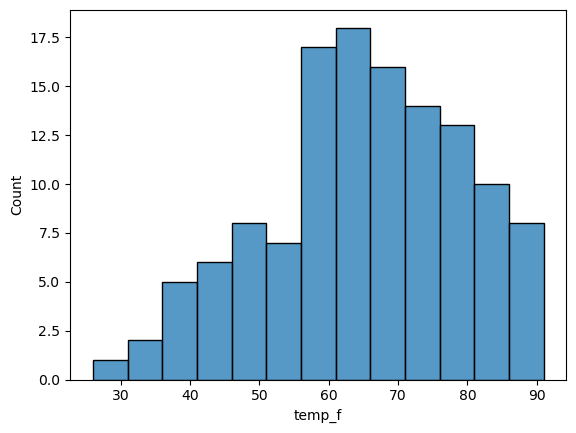

In [5]:
sns.histplot(data = full_df, x = 'temp_f', binwidth = 5)
plt.show()

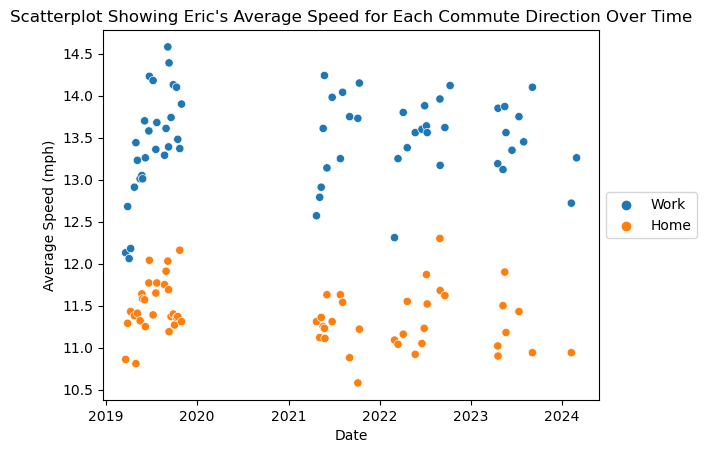

In [6]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

sns.scatterplot(data = full_df, x = 'date', y = 'avg_mph', hue = 'destination', ax = ax)
plt.title("Scatterplot Showing Eric's Average Speed for Each Commute Direction Over Time")
plt.ylabel('Average Speed (mph)')
plt.xlabel('Date')
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) 
plt.show()

Suddenly, we have a clear picture emerging. First, I can see that Eric was really taking biking seriously in 2019. He showed a general trend of picking up speed throughout the year on his commutes. I'll dive further into this shape later. We can also clearly see that Eric worked from home during all of 2020 due to COVID.

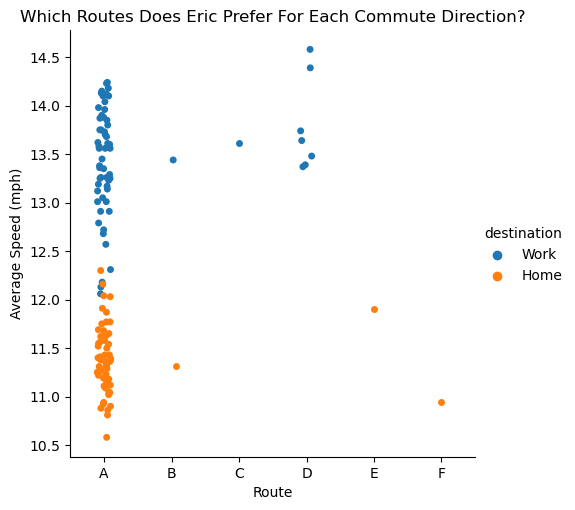

In [7]:
sns.catplot(data = full_df, x = 'route', y = 'avg_mph', hue = 'destination')
plt.title('Which Routes Does Eric Prefer For Each Commute Direction?')
plt.xlabel('Route')
plt.ylabel('Average Speed (mph)')
plt.show()

In [8]:
D_avg = full_df.loc[full_df['route'] == 'D']['avg_mph'].mean()
time_saved = (0.1 * 3600 / D_avg)
print(f'Eric averages {D_avg:0.2f} mph on route D.\nThe 0.1 mile savings over\
 route A accounts for a {time_saved:0.0f}-second savings on his morning commute.')

Eric averages 13.80 mph on route D.
The 0.1 mile savings over route A accounts for a 26-second savings on his morning commute.


Clearly Eric prefers route A. D appears to allow Eric a faster average speed, but I'll test that hypothesis later to see if we can definitively say D is a faster route. Eric has posted 2 speeds on route D that exceed his historical highs on route A. Time, however, is the confounding factor. Eric posted those speeds during the upward trend in 2019 when he was increasing his fitness level. He has yet to approach those speeds since taking 2020 off.

In [9]:
pd.crosstab(full_df['route'], full_df['weekday'])

weekday,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday
route,,,,,,
A,35,10,3,18,20,27
B,1,0,0,0,1,0
C,0,0,0,1,0,0
D,1,0,1,1,2,2
E,0,0,0,1,0,0
F,0,0,0,0,0,1


Does Eric seem to have some sort of weekday/bike route bias? No, he just seems to generally prefer route A and doesn't like to bike on Mondays. Maybe he often works from home on Mondays.

In [10]:
morning_2019_df = (full_df.loc[
                   (full_df['date'].dt.year == 2019) & 
                   (full_df['destination'] == 'Work')]
                  )

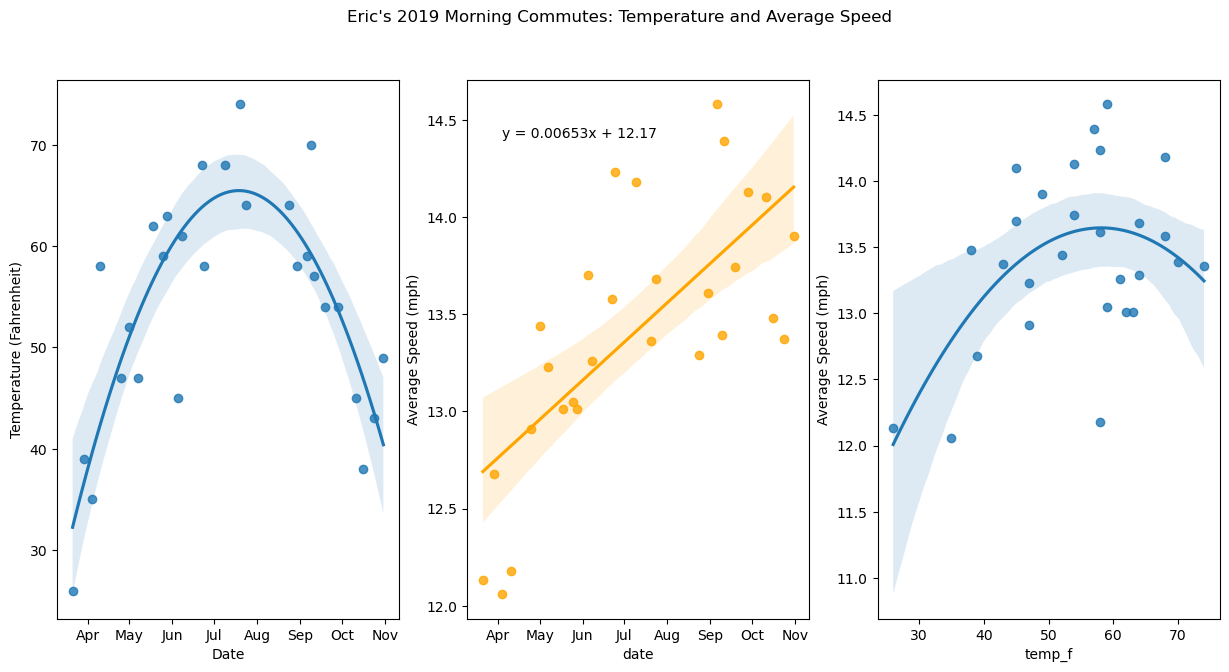

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 7))

ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].xaxis.set_major_formatter(DateFormatter("%b"))
ax[1].xaxis.set_major_locator(MonthLocator())
ax[1].xaxis.set_major_formatter(DateFormatter("%b"))

sns.regplot(
    x = morning_2019_df['date'].dt.dayofyear,
    y='temp_f',
    data = morning_2019_df,
    fit_reg=True,
    ci=95,  # Confidence interval at 95%
    order = 2,
    ax=ax[0]
)

ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
ax[1].set_xlabel('Temperature (Fahrenheit)')


l = sns.regplot(
    x = morning_2019_df['date'].dt.dayofyear,
    y = 'avg_mph',
    data = morning_2019_df,
    ax = ax[1],
    color = 'orange',
    order = 1
)

sns.regplot(
    y = 'avg_mph',
    x = 'temp_f',
    data = morning_2019_df,
    ax = ax[2],
    order = 2
)
    



plt.suptitle("Eric's 2019 Morning Commutes: Temperature and Average Speed")

ax[0].set_ylabel('Temperature (Fahrenheit)')
ax[1].set_ylabel('Average Speed (mph)')
ax[2].set_ylabel('Average Speed (mph)')

slope, intercept, r, p, sterr = scipy.stats.linregress(x = l.get_lines()[0].get_xdata(), y = l.get_lines()[0].get_ydata())

ax[1].text(0.1, 0.9, f'y = {slope:0.5f}x + {intercept:0.2f}', horizontalalignment='left', verticalalignment='center', transform=ax[1].transAxes)





plt.show()

It appears that date is a better predictor of temperature and speed than temperature is a predictor of speed. I also grabbed the slope and intercept of the speed vs date regression line to help inform my prior distribution for modeling later.

In [23]:
# Eric only ever used route D to go to work so I don't need to filter for destination.
d_2019_df = (full_df.loc[
             (full_df['route'] == 'D') & 
             (full_df['date'].dt.year == 2019)]
             [['date', 'avg_mph', 'temp_f']]
            ).reset_index(drop = True).assign(day_no = lambda x: x['date'].dt.dayofyear - 79)

d_2019_df

,date,avg_mph,temp_f,day_no
0,2019-09-05,14.58,59,169
1,2019-09-08,13.39,70,172
2,2019-09-10,14.39,57,174
3,2019-09-18,13.74,54,182
4,2019-10-15,13.48,38,209
5,2019-10-23,13.37,43,217


In [15]:
a_2019_df = (full_df.loc[
             (full_df['route'] == 'A') & 
             (full_df['date'].dt.year == 2019) & 
             (full_df['destination'] == 'Work')]
             [['date', 'avg_mph', 'temp_f']]
            ).reset_index(drop = True).assign(day_no = lambda x: x['date'].dt.dayofyear - 79) # Start at the date of the first ride
a_2019_df.head()

,date,avg_mph,temp_f,day_no
0,2019-03-20,12.13,26,0
1,2019-03-28,12.68,39,8
2,2019-04-03,12.06,35,14
3,2019-04-09,12.18,58,20
4,2019-04-24,12.91,47,35


### Hypothesis ###
My hypothesis is that route D has some topographical/infrastructure features that enable a higher average speed. What are the chances we'd see speeds at least this extreme if Eric were to have continued riding only route A in 2019? I already observed a positive trend in Eric's average pace over time in 2019, especially on his morning commute. I need to model the time-series distribution of these speeds and see if I ever observe any times as extreme as those he posted on route D when he posted them in september and October.

In [16]:
early_morning_df = (full_df.loc[
                        (full_df['destination'] == 'Work') & 
                        (full_df['route'] == 'A') & 
                        (full_df['date'].dt.month <= 4)][['date', 'avg_mph']])
early_morning_df.avg_mph.describe()

count    14.000000
mean     12.877857
std       0.596595
min      12.060000
25%      12.375000
50%      12.815000
75%      13.257500
max      13.850000
Name: avg_mph, dtype: float64

In [17]:
A_speed_df = (full_df.loc[
                  (full_df['route'] == 'A') &
                  (full_df['destination'] == 'Work')]
                  [['date', 'avg_mph']])
A_speed_df.avg_mph.describe()

count    55.000000
mean     13.422909
std       0.558837
min      12.060000
25%      13.130000
50%      13.560000
75%      13.860000
max      14.240000
Name: avg_mph, dtype: float64

When Eric begins riding for the season (defined as rides in January, February, March, or April), on specifically route A, he averages a speed of almost 13 mph on his way to work, with a standard deviation of 0.6 mph. I'll use this information to create my prior for Eric's base fitness level. Overall, his morning route A commute speed has an observed std of 0.56 mph.

## Model ##

### Assumptions ###
* Fitness level can be treated as linear over this short amount of time. It's likely more of a logarithmic curve over longer periods and parabolic over a lifetime. I'll assume Eric has some base fitness intercept and a fitness factor slope that causes his fitness level to increase over time with training.

    * $fitness_{day} = baseFitness + fitnessFactor * days + \epsilon$

* I'll assume that speed is directly proportional to fitness (disregarding temperature, route, day of the week, mood, etc.)
* I'll assume that Eric's true average pace is normally distributed for any given day
### Bayesian Model ###

* $speed \sim \mathcal{N}(baseFitness + fitnessFactor * day, \sigma)$
    * $speed \sim \mathcal{N}(\beta_0 + \beta_1 * day, \sigma)$
### Priors ###
* $\beta_0 \sim \mathcal{N}(12.875, 0.6)$ Assume base fitness (in terms of early season avg_mph) is normally distributed and centered around 12.875 with std 0.6
* $\beta_1 \sim \mathcal{N}(0.01, 0.5)$ Assume a speed increase of 0.01 mph per day with a lot of uncertainty
* $\sigma \sim \mathcal{N}(0, 1)$ Assume a wide standard deviation of speed, centered around 0

In [19]:
X = a_2019_df['day_no']
y = a_2019_df['avg_mph']

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [67]:
with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', mu = 12.875, sigma = 0.6) # Intercept prior
    beta_1 = pm.Normal('beta_1', mu = 0.01, sigma = 0.5) # Slope prior
    sigma = pm.Normal('sigma', mu = 0, sigma = 1) # Error term prior
    
    predicted_speed = beta_0 + beta_1 * X 
    likelihood = pm.StudentT('likelihood', nu = 19, mu = predicted_speed, sigma = sigma, observed = y)

    num_draws = 2000

    trace = pm.sample(num_draws, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


Text(0.5, 1.0, 'Posterior Predictive for normal likelihood')

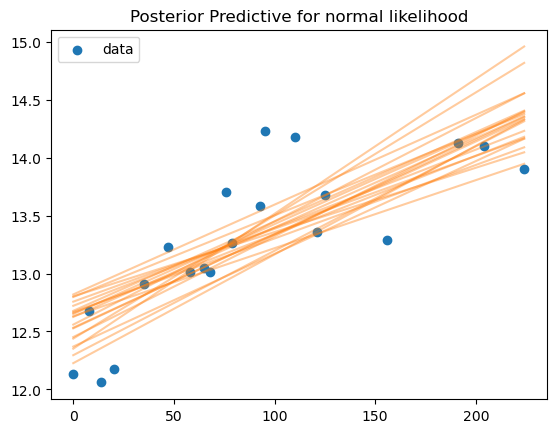

In [68]:
post = az.extract(trace, num_samples = 20)
x_plot = xr.DataArray(np.linspace(X.min(), X.max(), 100), dims = 'plot_id')
lines = post['beta_0'] + post['beta_1'] * x_plot

plt.scatter(X, y, label = 'data')
plt.plot(x_plot, lines.transpose(), alpha = 0.4, color = 'C1')
plt.legend(loc = 0)
plt.title('Posterior Predictive for normal likelihood')

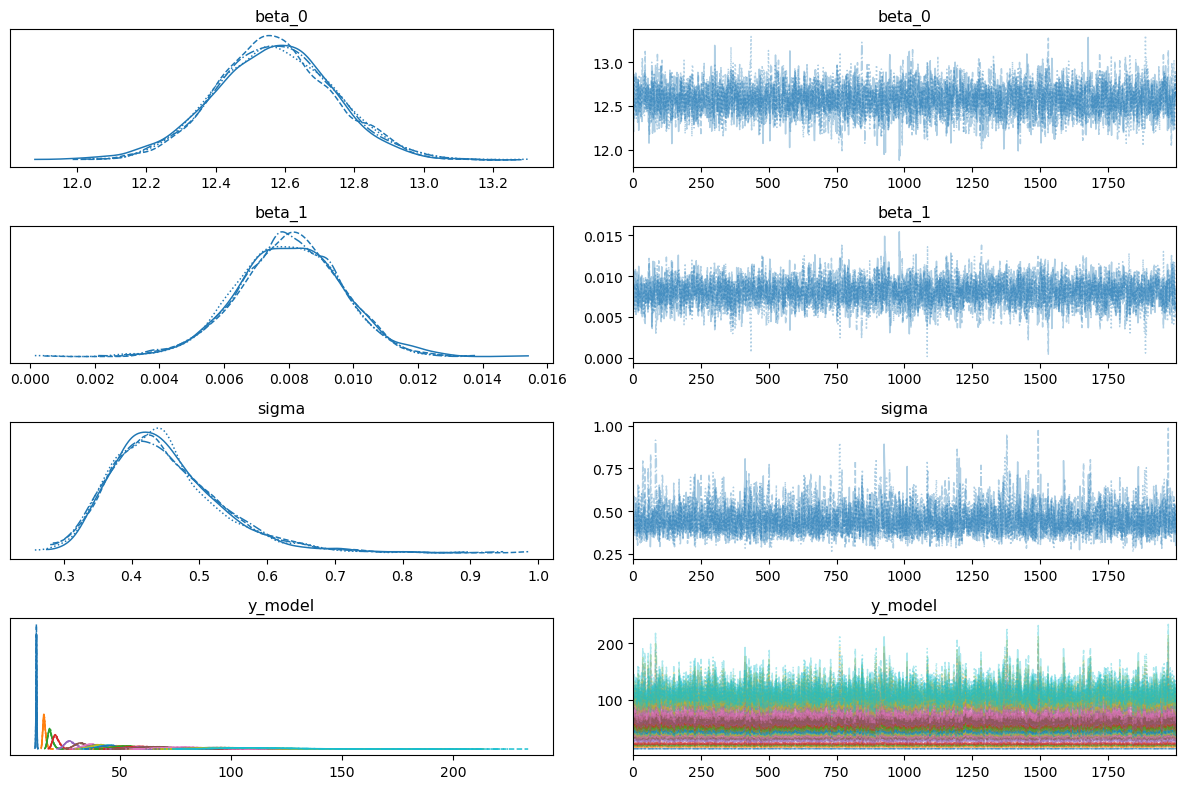

In [39]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

array([169, 172, 174, 182, 209, 217])

array([14.58, 13.39, 14.39, 13.74, 13.48, 13.37])

In [112]:
pd.set_option("display.precision", 6)
post_df = pd.DataFrame(az.summary(trace, round_to = 6))
post_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,12.577580,0.170475,12.252692,12.895897,0.003037,0.002148,3173.942692,3862.146244,1.001731
beta_1,0.007932,0.001566,0.004939,0.010856,0.000027,0.000019,3386.059817,3928.140595,1.000821
sigma,0.433738,0.081809,0.296974,0.585825,0.001457,0.001058,3436.891444,3147.715077,1.001228


In [113]:
beta_0_post = post_df.loc['beta_0']['mean']
beta_0_sd = post_df.loc['beta_0']['sd']

beta_1_post = post_df.loc['beta_1']['mean']
beta_1_sd = post_df.loc['beta_1']['sd']

sigma_post = post_df.loc['sigma']['mean']
sigma_sd = post_df.loc['sigma']['sd']

In [178]:
x_days = d_2019_df['day_no'].values

predicted_speeds = {}
predicted_means = []

for day in x_days:
    
    pred_speed_mean = beta_0_post + beta_1_post * day 

    pred_speed_dist = np.random.normal(pred_speed_mean, sigma_post, size = 1000)

    predicted_speeds.update({f'Day {day}': pred_speed_dist})
    predicted_means.append(pred_speed_mean.round(2))

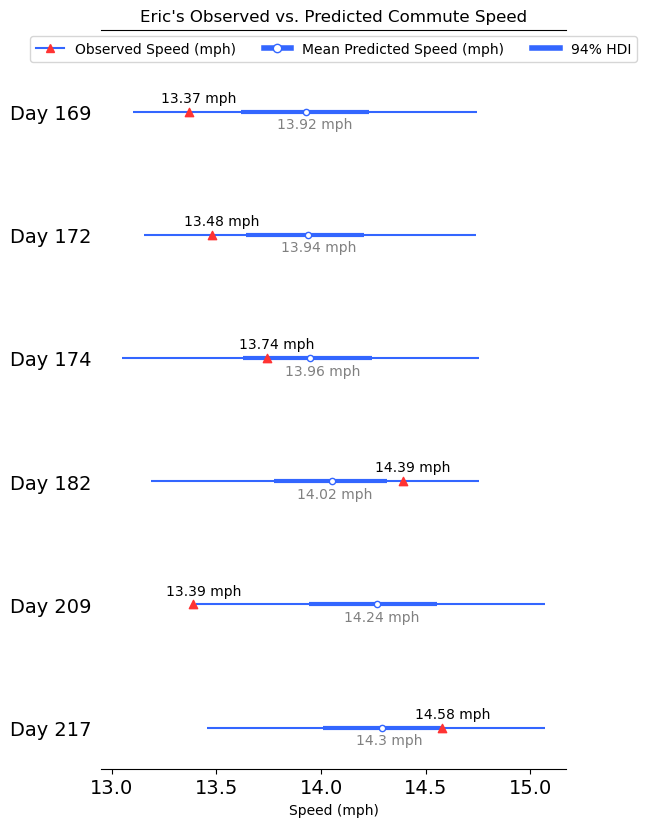

In [229]:
from matplotlib.lines import Line2D

d_speeds = d_2019_df['avg_mph'].values

axes = az.plot_forest(predicted_speeds, combined = True, colors = '#3366ff')#, linewidth = 2)
axis = axes[0]
ylocs = axis.yaxis.get_majorticklocs()
x_obs = d_speeds
x_pred = sorted(predicted_means, reverse = True)

axis.scatter(x_obs, ylocs, color = '#ff3333', marker = '^', zorder = 100)
axis.set_title("Eric's Observed vs. Predicted Commute Speed")
axis.set_xlabel('Speed (mph)')
for xo, yi in zip(x_obs, ylocs):
    axis.annotate(f'{xo} mph', xy = (xo, yi), xycoords = 'data', xytext = (-20, 7), textcoords = 'offset points', fontsize = 10)

for xp, yi in zip(x_pred, ylocs):
    axis.annotate(f'{xp} mph', xy = (xp, yi), xycoords = 'data', xytext = (-20, -12), textcoords = 'offset points', color = 'gray') 

legend_elements = [Line2D([0], 
                          [0], 
                          color = '#3366ff', 
                          markerfacecolor = '#ff3333', 
                          markeredgecolor = '#ff3333', 
                          label = 'Observed Speed (mph)', 
                          marker = '^'),
                   Line2D([0], 
                          [0], 
                          color = '#3366ff', 
                          markerfacecolor = 'white', 
                          markeredgecolor = '#3366ff', 
                          marker = 'o', 
                          linewidth = 4,
                          label = 'Mean Predicted Speed (mph)'),
                   Line2D([0], 
                          [0], 
                          color = '#3366ff', 
                          linewidth = 4, 
                          label = '94% HDI')
                  ]
axis.legend(handles = legend_elements, ncol = 3, loc = 'upper center')

plt.show()

#### Prove temp isn't a predictive factor by making a tree-based model using date and temp to predict speed. Use LIME/SHAP to show whether temp is/isn't a factor. ####